In [1]:
import platform
platform.python_version()

'3.6.7'

In [2]:
import os
CORPUS_PATH = os.path.join('./documents/state_of_union')
filenames = sorted([os.path.join(CORPUS_PATH, fn) for fn in os.listdir(CORPUS_PATH)])

# Function to display the words in each topic
def print_topic_words(ldamodel,n_topics,n_words):
    for i in ldamodel.print_topics(num_topics=n_topics, num_words=n_words):
        print(i[1])

In [3]:
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
import gensim

tokenizer = RegexpTokenizer(r'\w+')

# create English stop words list
en_stop = get_stop_words('en')
en_stop.append(['will','can','must','s'])

# Create p_stemmer of class PorterStemmer
p_stemmer = PorterStemmer()
    
#Our Document
filenames

# list for tokenized documents in loop
texts = []

# Non-tokenized texts
texts_nt = []

# loop through document list
for k in filenames:
    
    file = open(k,'r', encoding="utf8", errors='ignore') # open file
    
    # clean and tokenize document text
    raw_text = file.read().lower()
    
    tokens = tokenizer.tokenize(raw_text)
    
    # remove stop words from tokens
    stopped_tokens = [i for i in tokens if not i in en_stop]
    
    # stem tokens
    stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    
    # add tokens to list
    texts.append(stemmed_tokens)
    texts_nt.append(raw_text)
    
    file.close() # close file

# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary(texts)
    
# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(text) for text in texts]

# generate LDA model
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=2, id2word = dictionary, passes=20)

## Sentiment Analysis

In [4]:
from textblob import TextBlob
import pandas as pd
sentiments = [TextBlob(text).sentiment for text in texts_nt ] 

polarity = [ i[0] for i in sentiments]
subjectivity = [ i[1] for i in sentiments]

In [5]:
SOU_sentiments = pd.DataFrame(
    {'Filename': filenames,
     'Polarity': polarity,
     'Subjectivity': subjectivity
    })

SOU_sentiments['Year'] = SOU_sentiments.Filename.str.extract('(\d+)').astype(int)

In [6]:
type(SOU_sentiments['Year'][0])

numpy.int64

In [7]:
SOU_sentiments.head(5)

,Filename,Polarity,Subjectivity,Year
0,./documents/state_of_union/1945-Truman.txt,0.103764,0.556258,1945
1,./documents/state_of_union/1946-Truman.txt,0.111545,0.422838,1946
2,./documents/state_of_union/1947-Truman.txt,0.136731,0.409495,1947
3,./documents/state_of_union/1948-Truman.txt,0.165403,0.432409,1948
4,./documents/state_of_union/1949-Truman.txt,0.155075,0.456053,1949


In [8]:
#needed for graphs to display in jupyter notebook
%matplotlib inline 
# libraries
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")

### Sentiment Scores (Polarity) of Historical State of the Union Addresses

The sentiment analysis function we are using from the TextBlob library was apparently trained on movie reviews so it may not be the ideal tool for State of the Union Addresses.

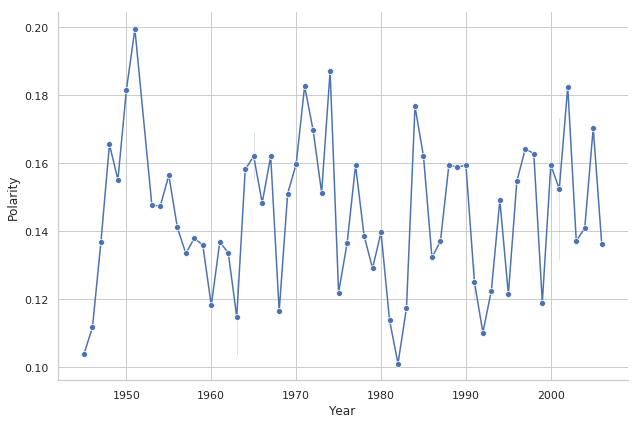

In [9]:
sns.relplot(x="Year", y="Polarity", data=SOU_sentiments,kind="line",marker="o",height=6,aspect=1.5)

## Topic Modeling

In [10]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=10, id2word = dictionary, passes=50)
print_topic_words(ldamodel,10,6)

0.015*"s" + 0.013*"year" + 0.012*"will" + 0.010*"american" + 0.010*"peopl" + 0.010*"work"
0.010*"s" + 0.007*"kid" + 0.006*"idea" + 0.006*"free" + 0.005*"capit" + 0.005*"europ"
0.018*"will" + 0.015*"year" + 0.012*"war" + 0.011*"dollar" + 0.009*"million" + 0.009*"program"
0.019*"will" + 0.016*"program" + 0.010*"tax" + 0.009*"year" + 0.008*"billion" + 0.008*"govern"
0.021*"will" + 0.010*"nation" + 0.010*"american" + 0.009*"world" + 0.009*"america" + 0.009*"must"
0.013*"nation" + 0.011*"will" + 0.009*"must" + 0.008*"program" + 0.008*"govern" + 0.008*"year"
0.014*"new" + 0.014*"america" + 0.013*"will" + 0.012*"year" + 0.011*"congress" + 0.011*"nation"
0.017*"s" + 0.013*"america" + 0.009*"us" + 0.009*"can" + 0.009*"famili" + 0.008*"will"
0.000*"will" + 0.000*"year" + 0.000*"s" + 0.000*"nation" + 0.000*"must" + 0.000*"peopl"
0.002*"deriv" + 0.001*"unswerv" + 0.001*"thee" + 0.001*"gladli" + 0.001*"defiant" + 0.001*"orat"


Using sklearn version of LDA instead: https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py 

In [53]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                stop_words='english')

tf = tf_vectorizer.fit_transform(texts_nt) # feed untransformed text to vectorizer

sklda = LatentDirichletAllocation(n_components=3,max_iter=50,
                                learning_method='online',
                               # learning_offset=50.,
                              #  random_state=0
                                 )
sklda.fit(tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=50, mean_change_tol=0.001,
             n_components=3, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [56]:
n_top_words = 15

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(sklda, tf_feature_names, n_top_words)

Topic #0: applause americans tonight let children ask ve budget care just tax health right want economy
Topic #1: federal program war economic free billion dollars programs shall million defense military economy tax strength
Topic #2: americans program tax federal economic war applause free long defense right economy budget children programs



In [58]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=4, id2word = dictionary, passes=30)
print_topic_words(ldamodel,3,7)

0.010*"american" + 0.010*"year" + 0.010*"america" + 0.009*"must" + 0.009*"peopl" + 0.008*"work" + 0.007*"nation"
0.013*"nation" + 0.009*"must" + 0.008*"world" + 0.007*"year" + 0.006*"peopl" + 0.006*"govern" + 0.006*"program"
0.013*"year" + 0.011*"war" + 0.011*"dollar" + 0.009*"million" + 0.009*"govern" + 0.008*"nation" + 0.008*"program"
